On Monday, September 20 2021, Canadians went to the polls and ended up electing a parliament that looked very much like the one we had in August, prior to the election. Very notably so. I'm not much of a political watcher, but I did wonder was this really so notably similar? Or do we just have short memories?

This is easy enough to answer.

## Methodology

What I would like to do is take a table with the number of seats each party got in each election and calculate the change in seats from one election to the next, then add that up. I can't simply add it up though, as the total number of seats (usually) remains constant and any party's gain is another party's loss: the total would always be zero. Instead I am going to add up the absolute value of the change, which effectively double counts each seat (it is counted when one party loses it and again when another party gains it). Also the total number of seats in the house of commons has not always been 338, to adjust for this I will take the absolute value of the change in percentage of seats. So, for example, if party A enters an election with 20% of the seats and leaves with 20% of the seats then this counts as no change, though if they entered with 20 seats and left with 20 seats but *the overall number of seats* had increased, then that counts as a change.

I can calculate this for each election and see how much of an outlier 2021 was.

In [1]:
using CSV, DataFrames, Statistics, Pipe, Plots

In [2]:
#| output: false

# takes a dataframe of the form
# | YEAR | party1 | party 2 | ... | party n |
# |------|--------|---------|-----|---------|
# | 1    |  100   |  50     | ... |   0     |
# |  :   |    :   |    :    |  :  |   :     |
# |  m   |   30   |   160   | ... |   1     |
# and returns a length m vector with the relative change for each year
function seat_change(df)
    
    # the first election seat change is undefined
    changes = [NaN]
    
    for i in 2:nrow(df)
        # starting with the second election
        prev = df[i-1, Not(:YEAR)]
        prev_total = sum(prev)
        
        curr = df[i, Not(:YEAR)]
        curr_total = sum(curr)
        
        Δseats = 0
        
        # for each party, calculate the absolute difference
        for j in 1:length(curr)
            
            prev_pct = prev[j]/prev_total
            curr_pct = curr[j]/curr_total
            Δseats += abs(curr_pct - prev_pct)
        end
        
        # add the change to the list
        push!(changes, Δseats)
    end
    
    return changes
end

seat_change (generic function with 1 method)

## Dataset

I pulled the seat count for each federal election since 1867 from [wikipedia](https://en.wikipedia.org/wiki/List_of_Canadian_federal_general_elections) as a CSV, with a little bit of finessing in the data entry. We have had a lot of political parties in our short time as a country and many of them either never ended up with any seats or only one or two before disappearing from history -- I have elected to lump these in with the independents as "Other". We have also had several parties that merged or changed, for example the CCF ultimately became the NDP and the Reform party became part of the Canadian Alliance, I have chosen to treat those as the same party.

Running this through the function I defined earlier gives the relative absolute seat change per election.

In [3]:
data_file = "data/federal-electon-results.csv"

results = @pipe data_file |>
    CSV.File( _ ;  header=1 ) |>
    DataFrame(_) |>
    hcat(_, seat_change(_)) |>
    rename(_, "x1" => "Change")

show(first(results, 6), allcols=true)

6×14 DataFrame
 Row │ YEAR   Other  Liberal  Conservatives  CCF/NDP  BQ     Progressive  Anti-Confederate  Social Credit  United Farmers  Reform/Canadian Alliance  Liberal Progressive  Unionist Coalition  Change      
     │ Int64  Int64  Int64    Int64          Int64    Int64  Int64        Int64             Int64          Int64           Int64                     Int64                Int64               Float64     
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │  1867      0       62            100        0      0            0                18              0               0                         0                    0                   0  NaN
   2 │  1872      5       95            100        0      0            0                 0              0               0                         0                    0              

## Results

Plotting the results gives us some interesting years to think about, such as 1917 when the government was composed of the [Unionist Coalition](https://en.wikipedia.org/wiki/Unionist_Party_(Canada)), a coalition of mostly Conservatives and some Liberals and others, that basically only existed for the war in what was, apparently, one of the most bitter campaigns in Canadian history. For the next election the coalition dissolved back into it's original parties, hence an enormous change going in and going out of that parliament. There are other large changes, like the 1993 election in which the Conservatives went into the election with 156 seats and left with 2, nearly being wiped out of parliament entirely -- the largest change in history according to this metric.

There have been periods of low change, the red-line on the plot indicates a change of less than 10%, but none as low as 2021. I do find it interesting that in the late 1800s and the early 1900s we had successive governments with very little change in overall composition but after 1908 things are a lot more variable.

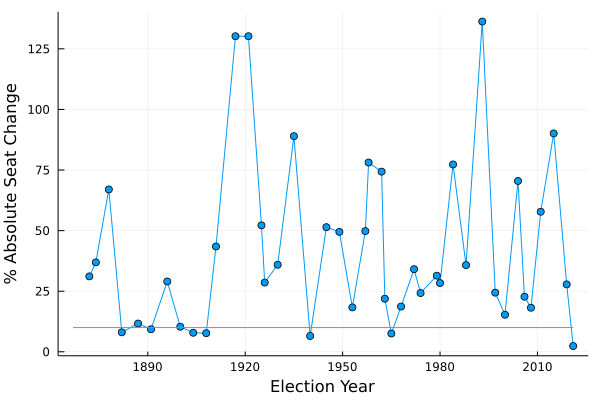

In [4]:
#| echo: false
#| label: fig-results
#| fig-cap: "Change in seats per Canadian Federal Election, 1867-2021"

p = plot(results[!, :YEAR], results[!, :Change] .* 100, lab=false,
     xlabel="Election Year", ylabel="% Absolute Seat Change", markershape=:circle)
plot!(p, [1867, 2021], [10, 10], lab=false)

plot(p)

We can filter out the low-change elections and get a sense of not just the 2021 election, but the neighbourhood of low-change elections.

In [5]:
lowest = filter(row -> row[:Change] < 0.10, results)

sort!(lowest, [:Change]);

In [6]:
#| echo: false

show(lowest[!, ["YEAR", "Liberal", "Conservatives", "BQ", "CCF/NDP", "Social Credit", "Liberal Progressive", "Other", "Change"]], allcols=true)

7×9 DataFrame
 Row │ YEAR   Liberal  Conservatives  BQ     CCF/NDP  Social Credit  Liberal Progressive  Other  Change    
     │ Int64  Int64    Int64          Int64  Int64    Int64          Int64                Int64  Float64   
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │  2021      158            119     34       25              0                    0      2  0.0236686
   2 │  1940      179             39      0        8             10                    3      6  0.0653061
   3 │  1965      131             97      0       21             14                    0      2  0.0754717
   4 │  1908      133             85      0        0              0                    0      3  0.0767539
   5 │  1904      137             75      0        0              0                    0      2  0.0784959
   6 │  1882       73            134      0        0              0                    0      4  0.0802926
   7 │  1891       9

This is an exceptionally low change, the next lowest year (1940) had &gt;2&times; as many seats change hands. Also, the last time the overall seat change was even close to this low was decades ago, the next previous year with a relative change &lt;10% was 1965 and in that case &gt;3&times; as many seats changed hands.

This result may change, as of right now several ridings are still too-close to call without mail in ballots, but for some of those if they flip it will actually lower the overall change in seats, not increase it. For example Edmonton Center is currently undecided with the Liberal candidate ahead, but if it flips to the incumbent Conservative the overall relative change for this election would go down.
